In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save output in a variable `df`

%%bigquery df --project fb-business-ws
SELECT order_number, created_at,
from fb-business-ws.enriched_marketing.shopify_orderlines

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Save output in a variable `df`

%%bigquery df --project fb-business-ws
SELECT order_number AS order_number
SELECT created_at AS created_at
SELECT cancelled_at AS cancelled_at
SELECT shipping_address_country_code AS shipping_address_country_code
SELECT shipping_address_province_code AS shipping_address_province_code
SELECT financial_status AS financial_status
SELECT email AS email
SELECT wholesale_tag AS wholesale_tag
SELECT meta_tag AS meta_tag
SELECT source_channel AS source_channel
SELECT sku AS sku
SELECT title AS title
SELECT quantity AS quantity
SELECT revenue AS revenue
SELECT net AS net
FROM fb-business-ws.enriched_marketing.shopify_orderlines
# WHERE net > 0 AND cancelled_at IS NULL AND source_name != 'shopify_draft_order' AND wholesale_tag is null AND financial_status != 'refunded'

Executing query with job ID: b184ef8d-4ffc-4be2-832c-b5152416345c
Query executing: 1.30s


ERROR:
 400 Syntax error: Expected end of input but got keyword SELECT at [2:1]; reason: invalidQuery, location: query, message: Syntax error: Expected end of input but got keyword SELECT at [2:1]

Location: US
Job ID: b184ef8d-4ffc-4be2-832c-b5152416345c



In [ ]:
df.head()

,order_number,created_at,cancelled_at,processed_at,updated_at,shipping_address_country_code,shipping_address_city,shipping_address_province_code,fulfillment_status,financial_status,...,meta_tag,source_channel,sku,title,price,quantity,revenue,pre_tax_price,total_discount,net
0,1551708,2023-07-05 16:36:45+00:00,NaT,2023-07-05 16:36:41+00:00,2023-07-19 01:11:38+00:00,US,Johnson Creek,WI,fulfilled,paid,...,None,tiktok,CW7172US,Best Anti-Frizz Curl Styling Set,54.4,1,54.4,54.4,0.0,54.4
1,1129337,2022-05-24 02:23:09+00:00,NaT,2022-05-24 02:23:07+00:00,2022-05-27 01:32:02+00:00,US,Kingston,PA,fulfilled,paid,...,None,None,CW7141,GAME-CHANGING Dream Clean Duo (Normal to Thick),36.0,1,36.0,28.8,0.0,36.0
2,1124968,2022-05-18 17:49:03+00:00,NaT,2022-05-18 17:49:00+00:00,2022-05-23 22:33:49+00:00,US,Lake City,SC,fulfilled,paid,...,None,Klaviyo,CW7102,GAME-CHANGING Dream Clean Duo (Fine to Normal),36.0,1,36.0,36.0,0.0,36.0
3,1158010,2022-06-28 17:59:57+00:00,NaT,2022-06-28 17:59:56+00:00,2022-06-30 19:31:15+00:00,US,Haverhill,MA,fulfilled,paid,...,None,None,CW7162,"Best Vacay Hair, Ever! Travel Kit",40.5,1,40.5,40.5,0.0,40.5
4,1112629,2022-05-04 08:13:33+00:00,NaT,2022-05-04 08:13:32+00:00,2022-05-11 23:36:08+00:00,US,San Antonio,TX,fulfilled,paid,...,None,None,CW208,Extra Mist-ical Shine Spray,16.0,1,16.0,16.0,0.0,16.0


In [ ]:
df.columns

Index(['order_number', 'created_at', 'cancelled_at', 'processed_at',
       'updated_at', 'shipping_address_country_code', 'shipping_address_city',
       'shipping_address_province_code', 'fulfillment_status',
       'financial_status', 'source_name', 'email', 'wholesale_tag', 'meta_tag',
       'source_channel', 'sku', 'title', 'price', 'quantity', 'revenue',
       'pre_tax_price', 'total_discount', 'net'],
      dtype='object')

In [ ]:
dff = df.drop(['processed_at', 'updated_at', 'shipping_address_city', 'fulfillment_status',
              'financial_status', 'source_name', 'price', 'pre_tax_price', 'total_discount'], axis=1)
dff.columns

Index(['order_number', 'created_at', 'cancelled_at',
       'shipping_address_country_code', 'shipping_address_province_code',
       'email', 'wholesale_tag', 'meta_tag', 'source_channel', 'sku', 'title',
       'quantity', 'revenue', 'net'],
      dtype='object')

#### Preprocessing Dataset   
1. `meta_tag`: drop 'Meta' values
2. `created_at`: if not cancelled than $→$ 1 order
3. `email`: drop blank values
3. `shipping_address_province_code`: if not US states than 'Other'
4. `interval`: create such a column to calculate the purchase interval
5. `source_channel`: keep the main channels
6. check if other columns containing null values or not
7. check data types and convert into wanted data types



In [ ]:
dff.shape

(3937055, 14)

In [ ]:
dff.isna().sum()

order_number                            1
created_at                              1
cancelled_at                      3920851
shipping_address_country_code        2665
shipping_address_province_code       2963
email                                   1
wholesale_tag                     3836422
meta_tag                          3762599
source_channel                    2579162
sku                                   547
title                                   1
quantity                                1
revenue                                 1
net                                     1
dtype: int64

In [ ]:
## drop 'Meta' values
dff['meta_tag'].unique
dff = dff[dff.meta_tag != 'Meta']
dff.shape

(3763012, 14)

In [ ]:
dff.dropna(subset=['email'], inplace=True)
dff.isna().sum()

order_number                            0
created_at                              0
cancelled_at                      3747705
shipping_address_country_code        2664
shipping_address_province_code       2962
email                                   0
wholesale_tag                     3662374
meta_tag                          3763011
source_channel                    2404848
sku                                   547
title                                   0
quantity                                0
revenue                                 0
net                                     0
dtype: int64

In [ ]:
## drop '' emails
dff.drop(dff[dff['email'] == ''].index, inplace=True)
dff.shape

(3683088, 14)

In [ ]:
## drop cancelled orders
dff = dff[pd.isnull(dff['cancelled_at'])]
dff.shape

(3668730, 14)

In [ ]:
## combine non-US province code into 'Other'
USstates = ['AL','AK','AZ','AR','AS','AE','AP','AA','CA','CO','CT','DE','DC','FL','GA','GU','HI','ID','IL','IN','IA','KS','KY','LA',
            'ME','MD','MA','MI','MN','MS','MO','MT','MP','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK',
            'OR','PA','PR','RI','SC','SD','TN','TX','UT','UM','VT','VI','VA','WA','WV','WI','WY']

dff.iloc[~dff['shipping_address_province_code'].isin(USstates),4] = 'Other'
print(dff['shipping_address_province_code'].nunique())
print(dff['shipping_address_province_code'].unique())

60
['CA' 'NC' 'MI' 'WI' 'ND' 'NJ' 'TX' 'OH' 'NY' 'SC' 'FL' 'ME' 'AR' 'CO'
 'WA' 'MD' 'KS' 'MO' 'HI' 'OR' 'MA' 'MS' 'DC' 'GA' 'IL' 'AL' 'NH' 'WV'
 'PA' 'IN' 'PR' 'VA' 'CT' 'ID' 'LA' 'KY' 'MN' 'UT' 'AZ' 'NE' 'TN' 'DE'
 'OK' 'Other' 'IA' 'NV' 'SD' 'RI' 'VI' 'NM' 'WY' 'MT' 'VT' 'AK' 'AE' 'AA'
 'GU' 'MP' 'AP' 'AS']


In [ ]:
## calculate purchasing intervals
dff = dff.sort_values(['email', 'created_at']) # sort by email & created_at at first
grouped = dff.groupby('email')
dff['interval'] = grouped['created_at'].diff().dt.days
dff['interval'] = dff['interval'].fillna(0)

In [ ]:
## clean the source_channel
print(dff['source_channel'].nunique())
print(dff['source_channel'].unique())
print(dff['source_channel'].value_counts(normalize=True) * 100)

219
[None 'daily-klaviyo' 'facebook' 'flow-klaviyo' 'flow-text' 'attentive'
 'Facebook' 'Klaviyo' 'dailycampaign-text-' 'dailycampaign-text  '
 'pinterest' 'hoobe' 'Pinterest' 'affiliate' 'homepage' 'tiktok'
 'dailycampaign-text ' 'TikTok' 'bing' 'flow-text  ' 'OrderlyEmails'
 'IGShopping' 'Paid' 'yotpo' 'dailycampaign-text' 'klarna' 'fb'
 'navigation' 'paid' '' 'listrak' 'loyalty' 'fbn' 'google' 'shop_app'
 'PaidSocial' 'youtube' 'SMSBump'
 'dailycampaign-text  utm_source=dailycampaign-text  '
 'Malomo Post Purchase: 4. Delivered' 'Facbook' 'Facebook_Mobile_Feed'
 'ig' 'Meta-SiteLink-644-2' 'drip' 'Google' 'Meta-SiteLink-1126-0'
 'B TRACK—Lightly Engaged (30-60 days)' 'Meta-SiteLink-3427-2' 'sfmc'
 'organic' 'mongoose' 'Iterable' 'active_campaign' 'flow klaviyo'
 'daily klaviyo' 'Meta-SiteLink-644-1' 'email' 'Meta-SiteLink-1133-0'
 'fbig' 'CTC FB' 'powereditor' 'Chris' 'Meta-SiteLink-190-0'
 'USPatriotFlags by Ultimate Flags LLCb' 'preflect' 'Tiktok' 'Proozy'
 'Digestive Support Prote

In [ ]:
dff.iloc[pd.isnull(dff['source_channel']),8] = 'Unkown'
dff.iloc[dff['source_channel'] == '',8] = 'Unkown'
print(dff['source_channel'].value_counts(normalize=True) * 100)

source_channel
Unkown                                                    64.488147
facebook                                                  12.521581
daily-klaviyo                                              6.771171
attentive                                                  2.931559
dailycampaign-text                                         2.064911
                                                            ...    
SMS Engaged 30 days, bought 365                            0.000027
makarov_fb                                                 0.000027
khangfujobi2newvid                                         0.000027
Growth Gurus | Omnilux LED | Engaged Contacts 365 Days     0.000027
tiktokad                                                   0.000027
Name: proportion, Length: 219, dtype: float64


In [ ]:
print(dff['source_channel'].unique())

['Unkown' 'daily-klaviyo' 'facebook' 'flow-klaviyo' 'flow-text'
 'attentive' 'Facebook' 'Klaviyo' 'dailycampaign-text-'
 'dailycampaign-text  ' 'pinterest' 'hoobe' 'Pinterest' 'affiliate'
 'homepage' 'tiktok' 'dailycampaign-text ' 'TikTok' 'bing' 'flow-text  '
 'OrderlyEmails' 'IGShopping' 'Paid' 'yotpo' 'dailycampaign-text' 'klarna'
 'fb' 'navigation' 'paid' 'listrak' 'loyalty' 'fbn' 'google' 'shop_app'
 'PaidSocial' 'youtube' 'SMSBump'
 'dailycampaign-text  utm_source=dailycampaign-text  '
 'Malomo Post Purchase: 4. Delivered' 'Facbook' 'Facebook_Mobile_Feed'
 'ig' 'Meta-SiteLink-644-2' 'drip' 'Google' 'Meta-SiteLink-1126-0'
 'B TRACK—Lightly Engaged (30-60 days)' 'Meta-SiteLink-3427-2' 'sfmc'
 'organic' 'mongoose' 'Iterable' 'active_campaign' 'flow klaviyo'
 'daily klaviyo' 'Meta-SiteLink-644-1' 'email' 'Meta-SiteLink-1133-0'
 'fbig' 'CTC FB' 'powereditor' 'Chris' 'Meta-SiteLink-190-0'
 'USPatriotFlags by Ultimate Flags LLCb' 'preflect' 'Tiktok' 'Proozy'
 'Digestive Support Protein 

In [ ]:
dff.iloc[dff['source_channel'].str.contains('fb|facebook|meta|facbook|facebad', case=False),8] = 'Facebook'
dff.iloc[dff['source_channel'].str.contains('ig|instagram', case=False),8] = 'Instagram'
dff.iloc[dff['source_channel'].str.contains('fb&ig', case=False),8] = 'Facebook&Instagram'
dff.iloc[dff['source_channel'].str.contains('tiktok', case=False),8] = 'Tiktok'
dff.iloc[dff['source_channel'].str.contains('pinterest', case=False),8] = 'Pinterest'
dff.iloc[dff['source_channel'].str.contains('youtube', case=False),8] = 'Youtube'
dff.iloc[dff['source_channel'].str.contains('paid|social', case=False),8] = 'Paid Social'

dff.iloc[dff['source_channel'].str.contains('bing', case=False),8] = 'Bing'
dff.iloc[dff['source_channel'].str.contains('google', case=False),8] = 'Google'

dff.iloc[dff['source_channel'].str.contains('hoobe', case=False),8] = 'Hoo.Be'
dff.iloc[dff['source_channel'].str.contains('klarna|shop|app', case=False),8] = 'Shop Apps'

dff.iloc[dff['source_channel'].str.contains('klaviyo', case=False),8] = 'Klaviyo'
dff.iloc[dff['source_channel'].str.contains('attentive', case=False),8] = 'Attentive'
dff.iloc[dff['source_channel'].str.contains('mail|newsletter|postscript|omnisend|seguno|braze|cordial|drip', case=False),8] = 'Email'
dff.iloc[dff['source_channel'].str.contains('sms|subscribe|text|flow', case=False),8] = 'Other SMS'

dff.iloc[dff['source_channel'].str.contains('loyalty|site|homepage|active|enthusiast', case=False),8] = 'Direct'

category = ['Unkown','Facebook','Instagram','Facebook&Instagram','Tiktok','Pinterest','Youtube','Paid Social','Bing','Google','Hoo.Be',
            'Shop Apps','Klaviyo','Attentive','Email','Other SMS','Direct']

print(dff['source_channel'].value_counts(normalize=True).head(10) * 100)
print(dff['source_channel'].unique())

source_channel
Unkown       64.488147
Facebook     13.705669
Klaviyo       9.783931
Instagram     3.518820
Attentive     2.931559
Other SMS     1.827281
Tiktok        1.503027
Pinterest     0.665407
Bing          0.463757
Hoo.Be        0.378769
Name: proportion, dtype: float64
['Unkown' 'Klaviyo' 'Facebook' 'Other SMS' 'Attentive' 'Instagram'
 'Pinterest' 'Hoo.Be' 'affiliate' 'Direct' 'Tiktok' 'Bing' 'Email'
 'Paid Social' 'yotpo' 'Shop Apps' 'listrak' 'Google' 'Youtube'
 'Malomo Post Purchase: 4. Delivered' 'sfmc' 'organic' 'mongoose'
 'Iterable' 'powereditor' 'Chris' 'USPatriotFlags by Ultimate Flags LLCb'
 'preflect' 'Proozy' '6259466001825' 'Impact' 'L | Abandoned Checkout'
 'Abandoned Cart - NEW YEARS SALE 2023' 'ReSci' '23854884683410564'
 'current' 'FX - Retention Full Engagement - 60 ' '360SWEATER HQ'
 'narrativ' 'GO' 'refersion' 'Lemonade Electrolytes (Tub)' 'junip'
 '30 days engage' 'chirp' 'broadcast' 'avantlink' '6290122498225' 'criteo'
 'linkinbio' 'Bees Wrap Master List' 

In [ ]:
dff.iloc[~dff['source_channel'].isin(category),8] = 'Other'
print(dff['source_channel'].nunique())
print(dff['source_channel'].unique())

17
['Unkown' 'Klaviyo' 'Facebook' 'Other SMS' 'Attentive' 'Instagram'
 'Pinterest' 'Hoo.Be' 'Other' 'Direct' 'Tiktok' 'Bing' 'Email'
 'Paid Social' 'Shop Apps' 'Google' 'Youtube']


In [ ]:
dff.head()

,order_number,created_at,cancelled_at,shipping_address_country_code,shipping_address_province_code,email,wholesale_tag,meta_tag,source_channel,sku,title,quantity,revenue,net,interval
887096,1065511,2022-04-30 17:05:12+00:00,NaT,US,PA,'tonyamiller32@yahoo.com,None,None,Unkown,CW232F,Free Travel Size Carb Cocktail,1,0.0,0.0,0.0
3170652,1065511,2022-04-30 17:05:12+00:00,NaT,US,PA,'tonyamiller32@yahoo.com,None,None,Unkown,CW527,Dream Coat Anti-Frizz Treatment,1,28.0,28.0,0.0
3340393,1065511,2022-04-30 17:05:12+00:00,NaT,US,PA,'tonyamiller32@yahoo.com,None,None,Unkown,CW508,Extra Mist-ical Shine Spray,1,29.0,29.0,0.0
3757122,1065511,2022-04-30 17:05:12+00:00,NaT,US,PA,'tonyamiller32@yahoo.com,None,None,Unkown,CW541,Root Cover Up in Blonde,1,34.5,34.5,0.0
1741934,1618165,2023-08-09 20:05:18+00:00,NaT,US,MA,+1508596smbak55@gmail.com,None,None,Unkown,CW548,Dream Filter For Picture-Perfect Color,1,24.0,24.0,0.0


In [ ]:
dff.isna().sum()

order_number                            0
created_at                              0
cancelled_at                      3668342
shipping_address_country_code        2637
shipping_address_province_code          0
email                                   0
wholesale_tag                     3568287
meta_tag                          3668342
source_channel                          0
sku                                   491
title                                   0
quantity                                0
revenue                                 0
net                                     0
interval                                0
dtype: int64

In [ ]:
df1 = dff.drop(['cancelled_at', 'shipping_address_country_code', 'meta_tag'], axis=1)
df1.columns

Index(['order_number', 'created_at', 'shipping_address_province_code', 'email',
       'wholesale_tag', 'source_channel', 'sku', 'title', 'quantity',
       'revenue', 'net', 'interval'],
      dtype='object')

In [ ]:
df1.iloc[pd.isnull(dff['wholesale_tag']),4] = 'No'

In [ ]:
df1.dtypes

order_number                                    Int64
created_at                        datetime64[us, UTC]
shipping_address_province_code                 object
email                                          object
wholesale_tag                                  object
source_channel                                 object
sku                                            object
title                                          object
quantity                                        Int64
revenue                                       float64
net                                           float64
interval                                      float64
dtype: object

In [ ]:
df1 = df1.astype({'order_number': object})
print(df1.dtypes)

order_number                                   object
created_at                        datetime64[us, UTC]
shipping_address_province_code                 object
email                                          object
wholesale_tag                                  object
source_channel                                 object
sku                                            object
title                                          object
quantity                                        Int64
revenue                                       float64
net                                           float64
interval                                      float64
dtype: object


In [ ]:
############ RUN THIS #############
def clean_orderlines(df):
  dff = df.drop(['processed_at', 'updated_at', 'shipping_address_city', 'fulfillment_status','financial_status', 'source_name',
                 'price', 'pre_tax_price', 'total_discount'], axis=1)
  dff = dff[dff.meta_tag != 'Meta'] # drop Meta records
  dff.dropna(subset=['email'], inplace=True) # drop null email records
  dff.drop(dff[dff['email'] == ''].index, inplace=True) # drop ' ' email records
  dff = dff[pd.isnull(dff['cancelled_at'])] # drop cancelled orders

  ## combine non-US province code into 'Other'
  USstates = ['AL','AK','AZ','AR','AS','AE','AP','AA','CA','CO','CT','DE','DC','FL','GA','GU','HI','ID','IL','IN','IA','KS','KY','LA',
            'ME','MD','MA','MI','MN','MS','MO','MT','MP','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK',
            'OR','PA','PR','RI','SC','SD','TN','TX','UT','UM','VT','VI','VA','WA','WV','WI','WY']
  dff.iloc[~dff['shipping_address_province_code'].isin(USstates),4] = 'Other'

  ## calculate purchasing intervals
  dff = dff.sort_values(['email', 'created_at'])
  grouped = dff.groupby('email')
  dff['interval'] = grouped['created_at'].diff().dt.days
  dff['interval'] = dff['interval'].fillna(0)

  ## clean the source_channel
  dff.iloc[pd.isnull(dff['source_channel']),8] = 'Unkown'
  dff.iloc[dff['source_channel'] == '',8] = 'Unkown'
  dff.iloc[dff['source_channel'].str.contains('fb|facebook|meta|facbook|facebad', case=False),8] = 'Facebook'
  dff.iloc[dff['source_channel'].str.contains('ig|instagram', case=False),8] = 'Instagram'
  dff.iloc[dff['source_channel'].str.contains('fb&ig', case=False),8] = 'Facebook&Instagram'
  dff.iloc[dff['source_channel'].str.contains('tiktok', case=False),8] = 'Tiktok'
  dff.iloc[dff['source_channel'].str.contains('pinterest', case=False),8] = 'Pinterest'
  dff.iloc[dff['source_channel'].str.contains('youtube', case=False),8] = 'Youtube'
  dff.iloc[dff['source_channel'].str.contains('paid|social', case=False),8] = 'Paid Social'
  dff.iloc[dff['source_channel'].str.contains('bing', case=False),8] = 'Bing'
  dff.iloc[dff['source_channel'].str.contains('google', case=False),8] = 'Google'
  dff.iloc[dff['source_channel'].str.contains('hoobe', case=False),8] = 'Hoo.Be'
  dff.iloc[dff['source_channel'].str.contains('klarna|shop|app', case=False),8] = 'Shop Apps'
  dff.iloc[dff['source_channel'].str.contains('klaviyo', case=False),8] = 'Klaviyo'
  dff.iloc[dff['source_channel'].str.contains('attentive', case=False),8] = 'Attentive'
  dff.iloc[dff['source_channel'].str.contains('mail|newsletter|postscript|omnisend|seguno|braze|cordial|drip', case=False),8] = 'Email'
  dff.iloc[dff['source_channel'].str.contains('sms|subscribe|text|flow', case=False),8] = 'Other SMS'
  dff.iloc[dff['source_channel'].str.contains('loyalty|site|homepage|active|enthusiast', case=False),8] = 'Direct'

  category = ['Unkown','Facebook','Instagram','Facebook&Instagram','Tiktok','Pinterest','Youtube','Paid Social','Bing','Google','Hoo.Be',
            'Shop Apps','Klaviyo','Attentive','Email','Other SMS','Direct']
  dff.iloc[~dff['source_channel'].isin(category),8] = 'Other'


  df1 = dff.drop(['cancelled_at', 'shipping_address_country_code', 'meta_tag'], axis=1)
  df1.iloc[pd.isnull(dff['wholesale_tag']),4] = 'No'
  df1 = df1.astype({'order_number': object})

  return df1

df = clean_orderlines(df)

#### Analysis
1. Define retention rate
2. Hypothesis: `wholesale_tag` affects the retention rate
3. Which `source_channel` has the higer retention rate (different years)
4. how do different products behave on retention rate (different years)
5. Hypothesis: the total revenue on each pruchase affects the retention rate


In [ ]:
print(df1.shape)
print(df1['wholesale_tag'].isna().sum())

(3668342, 12)
0


In [ ]:
print(df1['wholesale_tag'].value_counts(normalize=True) * 100)
print(df1.groupby(['wholesale_tag'])['net'].mean())

wholesale_tag
No           97.272474
wholesale     2.727526
Name: proportion, dtype: float64
wholesale_tag
No           25.029814
wholesale    51.618263
Name: net, dtype: float64
wholesale_tag
No           15.436722
wholesale     2.656509
Name: interval, dtype: float64


Text(0.5, 1.0, 'Distribution of Interval')

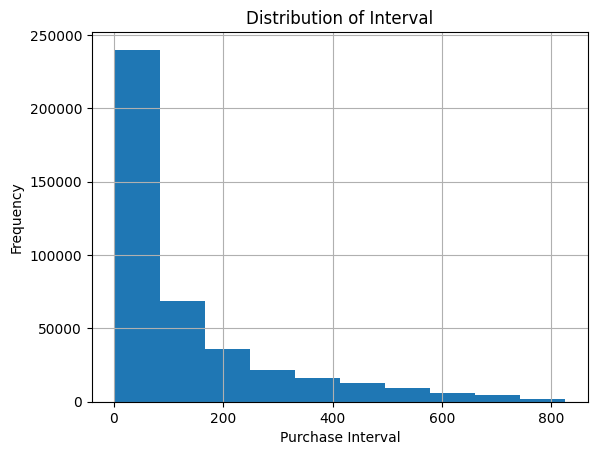

In [ ]:
df1[df1['interval'] != 0]['interval'].hist()
plt.xlabel('Purchase Interval')
plt.ylabel('Frequency')
plt.title('Distribution of Interval')